# Fashion MNIST Classification using CNN Model

# Prerequisites

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Loading and Preprocess

In [2]:
# Load and divide Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

print('Shape of X_train: {}\tShape of X_test: {}'.format(X_train.shape, X_test.shape))
print('Shape of y_train: {}\t\tShape of y_test: {}'.format(y_train.shape, y_test.shape))

4431872/4422102 [==============================] - 0s 0us/step
Shape of X_train: (60000, 28, 28)	Shape of X_test: (10000, 28, 28)
Shape of y_train: (60000,)		Shape of y_test: (10000,)


2022-02-21 07:36:50.293702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 07:36:50.391925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 07:36:50.392646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 07:36:50.395208: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

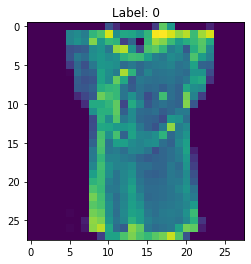

(28, 28)

In [3]:
# Generate a random number and use it as index
rand_index = tf.random.uniform(shape=(), minval=1, maxval=60000, dtype=tf.int32)

plt.imshow(X_train[rand_index])
plt.title('Label: {}'.format(y_train[rand_index]))
plt.show()
X_train[rand_index].shape

In [4]:
# Print some properties of X_train and X_test
print('dtype =', X_train[rand_index].dtype)
print('min =', X_train[rand_index].min())
print('max =', X_train[rand_index].max())
print('range =', X_train[rand_index].ptp())

dtype = uint8
min = 0
max = 255
range = 255


In [5]:
# Type casting to floating point 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Scale the data
X_train = X_train / 255
X_test = X_test / 255

In [6]:
# Apply one hot encoder
y_train = tf.one_hot(y_train, 10)

print('Label of sample #{} is {}.'.format(
    rand_index,
    y_train[rand_index]
))

Label of sample #53068 is [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.].


# Modeling 

## Custom Callback

In [7]:
# create class for custom callbacks
class ThresholdCallback(keras.callbacks.Callback):
    """
    Threshold Callback for keras.models

    Parameters
    ------------
    point: float (between 0 and 1)
    """
    def __init__(self, point):
        super(ThresholdCallback, self).__init__()
        # Threshhold for stop training process if it become reached
        self.point = point

    def on_batch_end(self, epoch, logs=None):
        # Check for reaching specified point
        if logs['accuracy'] >= self.point:
            self.model.stop_training = True

## CNN Model with RMSProp Optimizer

In [8]:
# Define CNN model
model = keras.models.Sequential(
    [
     layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
     layers.MaxPooling2D((2, 2)),
     layers.Flatten(),
     layers.Dense(100),
     layers.Dense(10, activation='sigmoid')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1081700   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 1,083,350
Trainable params: 1,083,350
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Comile model
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [10]:
# Justify dimension for model use
X_train = np.expand_dims(X_train, axis=-1)

# Fit model to data with cutstom callbacks
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=10,
    callbacks=ThresholdCallback(0.95),
    validation_split=0.2,
    verbose=1
)

2022-02-21 07:36:53.820262: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-02-21 07:36:55.114798: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


750/750 [==============================] - 9s 4ms/step - loss: 0.4124 - accuracy: 0.8537 - val_loss: 0.3107 - val_accuracy: 0.8889
Epoch 2/10
750/750 [==============================] - 3s 3ms/step - loss: 0.2843 - accuracy: 0.8999 - val_loss: 0.2812 - val_accuracy: 0.9022
Epoch 3/10
750/750 [==============================] - 1s 852us/step - loss: 0.1331 - accuracy: 0.9531 - val_loss: 0.2785 - val_accuracy: 0.9013


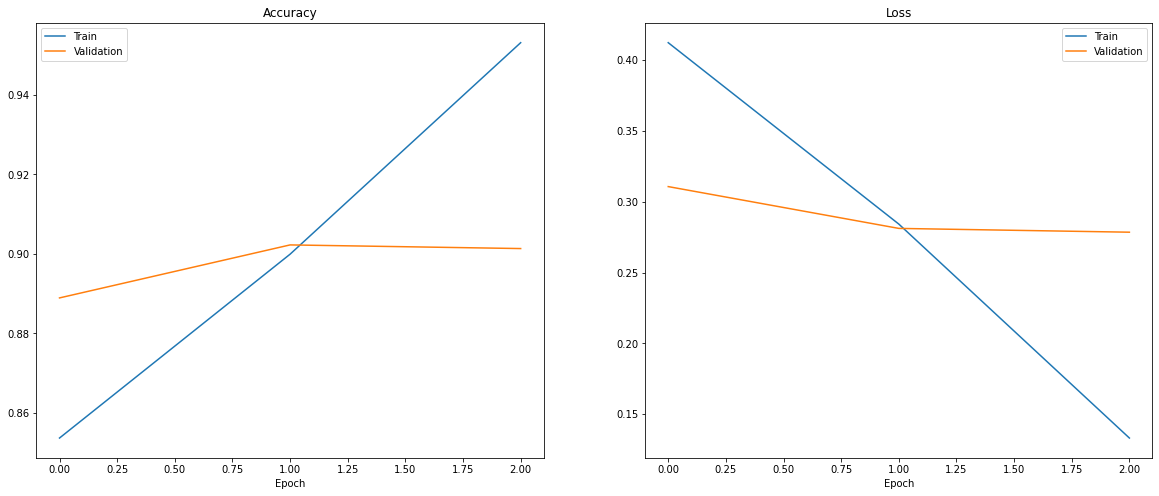

In [11]:
# Ploting accuracy values
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')

# Ploting loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')

plt.show()

## CNN Model with Adam Optimizer

In [12]:
# Define CNN model
model = keras.models.Sequential(
    [
     layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
     layers.MaxPooling2D((2, 2)),
     layers.Flatten(),
     layers.Dense(100),
     layers.Dense(10, activation='sigmoid')
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               1081700   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 1,083,350
Trainable params: 1,083,350
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Comile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [14]:
# Fit model to data with cutstom callbacks
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=10,
    callbacks=ThresholdCallback(0.95),
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
750/750 [==============================] - 4s 5ms/step - loss: 0.4028 - accuracy: 0.8587 - val_loss: 0.3124 - val_accuracy: 0.8895
Epoch 2/10
750/750 [==============================] - 2s 3ms/step - loss: 0.2860 - accuracy: 0.8991 - val_loss: 0.2858 - val_accuracy: 0.8979
Epoch 3/10
750/750 [==============================] - 2s 3ms/step - loss: 0.2509 - accuracy: 0.9109 - val_loss: 0.2806 - val_accuracy: 0.9023
Epoch 4/10
750/750 [==============================] - 0s 547us/step - loss: 0.1027 - accuracy: 0.9531 - val_loss: 0.2901 - val_accuracy: 0.9007


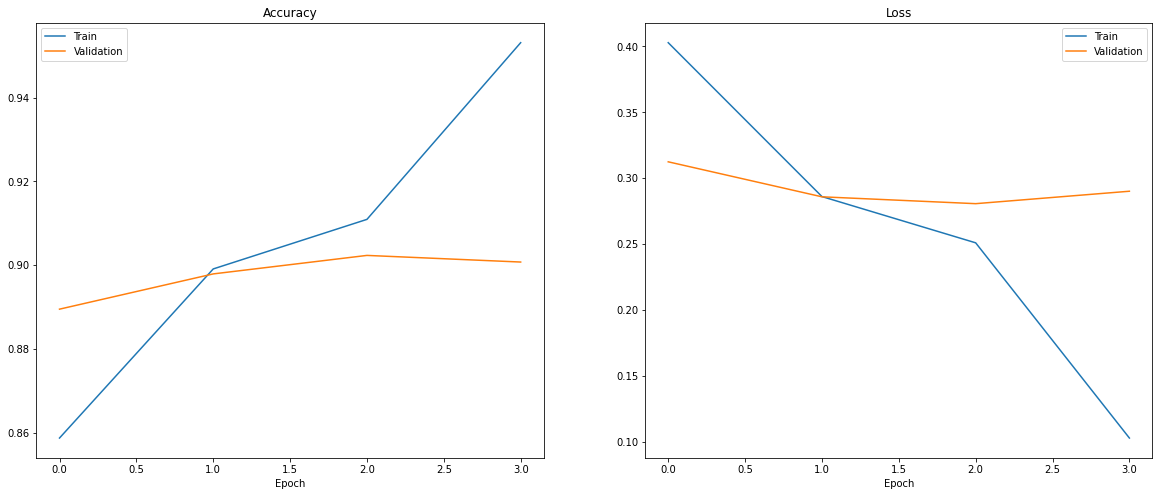

In [15]:
# Ploting accuracy values
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')

# Ploting loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')

plt.show()

As we can see in the above figures, model with Adam optimizer reached 0.95 accuracy sooner than RMSProp optimizer. On the other hand, the difference between train accuracy and validation accuracy is larger using Adam which could be a reason for tendention of this model to overfitting the training data.

# Test Model

In [16]:
output = model.predict(np.expand_dims(X_test, axis=-1))
preds = np.argmax(output, axis=1)

print('Accuracy on test set: {}'.format(
    np.sum(preds==y_test) / len(y_test)
    )
)

Accuracy on test set: 0.8937
